In [160]:
from clustergram import Clustergram
from concurrent.futures import wait, ALL_COMPLETED
#from fracdiff import fdiff
from numpy import absolute
from numpy import arange
from numpy import mean
from numpy import std
from pandas import read_csv
from pandas_profiling import ProfileReport
from rpy2.robjects import pandas2ri
from scipy import stats
from scipy.special import boxcox, inv_boxcox
from scipy.stats import f
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import *
from sklearn.preprocessing import scale
from statsmodels.tsa.ar_model import AutoReg
import IPython
import concurrent.futures
import dtale
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import rpy2.robjects as ro
import scipy
import seaborn as sns
import shap
import sklearn
import statsmodels.api as sm
import sys
#import urbangrammar-graphics as ugg

In [161]:
#if not sys.warnoptions:
#    import warnings
#    warnings.simplefilter("ignore")

wd = os.getcwd()

if (os.defpath==".;C:\\bin"):
    os.environ['R_HOME'] = 'C:/Users/User/Documents/R/R-4.1.2'
    os.environ['R_LIBS'] = 'C:/Users/User/Documents/R/R-4.1.2/library'
    from OLS_LR_DiagnosticPlots.ModelDiagnostics import Plot
else:
    os.environ['R_HOME'] = '/mnt/distvol/R/4.0.5/lib64/R/'

pandas2ri.activate()


In [162]:
from sklearn.preprocessing import PowerTransformer

def testNormal (x):    
    
    k2, p = stats.normaltest(x)
    alpha = .001
    #print("p = {:g}".format(p))    
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        #print(p)
        #print(alpha)
        print("The null hypothesis can be rejected")
        xt, _ = stats.yeojohnson(x)
        #xt, _ = stats.boxcox(x)        
        print(_)
        xt = pd.DataFrame(xt)
        
        return _, pd.DataFrame(xt).set_index(x.index)
    else:
        print("The null hypothesis cannot be rejected")    
        return 1, pd.DataFrame(x)

def inverse_boxcox (data, lambdas):
    power = PowerTransformer(method='yeo-johnson')
    power.lambdas_ = lambdas.values
    return(power.inverse_transform([data]))
    #return inv_boxcox(data, lambdas.values)
    
def transform_boxcox_l(data, l_):
    transformed = pd.DataFrame()

    for i in range(0,len(data.columns)):
        #print(i)
        if l_.iloc[i].values == 1:
            inner_scale = data.iloc[:,i]            
        else:
            inner_scale = pd.DataFrame(stats.yeojohnson((data.iloc[:,i]), lmbda=l_.iloc[i].values))
            
        inner_scale.index = data.index
        transformed = pd.concat([transformed,inner_scale],axis=1)
        
    transformed.columns = data.columns
    return transformed

def transform_boxcox (data):
    transformed = pd.DataFrame()
    transformed_lambdas = pd.DataFrame()

    for i in range(0,len(data.columns)):
        l, inner_scale = testNormal(data.iloc[:,i])
        inner_scale.set_index(data.index)

        transformed_lambdas = pd.concat([transformed_lambdas,pd.DataFrame(pd.Series(l))],axis=0)
        transformed = pd.concat([transformed,inner_scale],axis=1)
        
    transformed.columns = data.columns
    return transformed, transformed_lambdas

def inverse_yeo(og, data_, lambda_):
    values = []
    for i in range(0,len(og)):
        X = og[i]
        X_trans = data_[i]
        if X >= 0 and lambda_ == 0:
            X = exp(X_trans) - 1
        elif X >= 0 and lambda_ != 0:
            X = (X_trans * lambda_ + 1) ** (1 / lambda_) - 1
        elif X < 0 and lambda_ != 2:
            X = 1 - (-(2 - lambda_) * X_trans + 1) ** (1 / (2 - lambda_))
        elif X < 0 and lambda_ == 2:
            X = 1 - exp(-X_trans)
        
        values.append(X)
    return(pd.DataFrame(values))


def revert_yeo (og, data_, lambdas):
    reverted = pd.DataFrame()

    for i in range(0,len(data_.columns)):        
        if lambdas.iloc[i].values == 1 :
            revert = data_.iloc[:,i]
        else:
            p#ower = PowerTransformer(method='yeo-johnson')
            #power.lambdas_ = lambdas.iloc[i].values
            #revert = pd.DataFrame(power.inverse_transform([data.iloc[:,i].values]))
            #return inv_boxcox(data, lambdas.values)
            revert = pd.DataFrame(inverse_yeo(og.iloc[:,i].values,data_.iloc[:,i].values, lambdas.iloc[i].values))            
        revert.index = data_.index
        reverted = pd.concat([reverted,revert],axis=1)
        
    reverted.columns = data_.columns
    return reverted


In [163]:
def get_deltas(data):

    R.r('''
               f <- function(values) {
                        #system("which openssl")

                        library(snpEnrichment)
                        library(arfima)
                        library(parallel)
                        library(forecast)                    

                        dset <- lapply(1:ncol(values),function(x)
                        {
                            column = values[,x]


                            #tryCatch(invisible(capture.output(suppressMessages(suppressWarnings(
                            #{
                              varvefd = arfima(column)
                              d = summary(varvefd)$coef[[1]][1]
                              
                              r = residuals(varvefd, reg = TRUE)
                              #print(r)
                              return(d)
                            #}
                           #)
                           #))),
                            #error=function(e)
                              #{
                                #d = 1
                                #return(d)
                              #})

                        })    

                        unlist(dset)

                }
                ''')

    r_f = R.globalenv['f']
    d=R.conversion.rpy2py((r_f(R.conversion.py2rpy(data.dropna()))))
    return(d)

def get_residuals(data):

    R.r('''
               f <- function(values) {
                        #system("which openssl")

                        library(snpEnrichment)
                        library(arfima)
                        library(parallel)
                        library(forecast)                    

                        dset <- lapply(1:ncol(values),function(x)
                        {
                            column = values[,x]


                            #tryCatch(invisible(capture.output(suppressMessages(suppressWarnings(
                            #{
                              varvefd = arfima(column)
                              d = summary(varvefd)$coef[[1]][1]
                              
                              #return(d)
                              r = residuals(varvefd, reg = TRUE)
                              #print(r)
                              return(r)
                            #}
                           #)
                           #))),
                            #error=function(e)
                              #{
                                #d = 1
                                #return(d)
                              #})

                        })    

                        unlist(dset)

                }
                ''')

    r_f = R.globalenv['f']
    d=R.conversion.rpy2py((r_f(R.conversion.py2rpy(data.dropna()))))
    return(d)

def arfima_predict(data_, ahead):

    R.r('''
               f_ <- function(values, ahead) {
                        #system("which openssl")
                        print(nrow(values))

                        library(snpEnrichment)
                        library(arfima)
                        library(parallel)
                        library(forecast)                    

                        dset <- lapply(1:ncol(values),function(x)
                        {
                            column = values[,x,drop=FALSE]


                            #tryCatch(invisible(capture.output(suppressMessages(suppressWarnings(
                            #{
                              varvefd = arfima(column)
                              d = summary(varvefd)$coef[[1]][1]
                              
                              #return(d)
                              r = residuals(varvefd, reg = TRUE)
                              #print(r)
                              #return(r)
                              
                              pred <- predict(varvefd, ahead)
                              #print(ahead)
                              #print(pred)
                              #print(pred)
                              return(as.data.frame(pred)[,1,drop=TRUE])
                            #}
                           #)
                           #))),
                            #error=function(e)
                              #{
                                #d = 1
                                #return(d)
                              #})

                        })    

                        unlist(dset)

                }
                ''')

    r_f_ = R.globalenv['f_']
    d_=R.conversion.rpy2py((r_f_(R.conversion.py2rpy(data_),ahead)))
    return(d_)


In [164]:


def arima_adjust(y_train, y_test, train_predicted, test_predicted):
    
    #arima residual adjusted
    
    window = 15
    train_resid = y_train - pd.DataFrame(train_predicted).set_index(y_train.index)

    model = AutoReg(train_resid.values, lags=15)
    model_fit = model.fit()
    coef = model_fit.params
    # walk forward over time steps in test
    history = train_resid[len(train_resid)-window:]
    history = [history.loc[history.index[i]] for i in range(len(history))]
    predictions = list()
    for t in range(len(y_test)):
        # persistence
        yhat = pd.DataFrame(test_predicted).set_index(y_test.index).loc[y_test.index[t]]    
        error = y_test.loc[y_test.index[t]] - yhat
        # predict error
        length = len(history)
        lag = [history[i] for i in range(length-window,length)]
        pred_error = coef[0]
        for d in range(window):
            pred_error += coef[d+1] * lag[window-d-1]
        # correct the prediction
        yhat = yhat + pred_error
        #print(yhat)
        predictions.append(np.round(yhat,0).astype(int))
        history.append(error)
        #print('predicted=%f, expected=%f' % ((np.round(yhat,0)), y_test.loc[y_test.index[t]]))

    print(metrics.classification_report(y_test,predictions))
    print(metrics.confusion_matrix(y_test,predictions))
    
    return(pd.DataFrame(predictions).set_index(y_test.index))

In [165]:
#arfima residual adjusted
def arfima_adjust(y_train, y_test, train_predicted, test_predicted):
    
    #train_resid = get_deltas(y_train)
    train_resid = y_train - pd.DataFrame(train_predicted).set_index(y_train.index)

    y_adjusted = predicted.copy()

    forecast_r = arfima_predict(train_resid.values, len(y_test))  
    print(len(forecast_r))
    
    # walk forward over time steps in test
    #history = train_resid[len(train_resid):-1]
    #history = [history.loc[history.index[i]] for i in range(len(history))]
    predictions = list()
    for t in range(len(y_test)):
        # persistence
        yhat = pd.DataFrame(test_predicted).set_index(y_test.index).loc[y_test.index[t]]
        #error = y_test.loc[y_test.index[t]] - yhat
        # predict error
        #length = len(history)
        #lag = [history[i] for i in range(length-window,length)]
        #pred_error = coef[0]
        #for d in range(window):
            #pred_error += coef[d+1] * lag[window-d-1]
        # correct the prediction
        #print(yhat)
        #print(pd.DataFrame(forecast_r).set_index(y_test.index).loc[y_test.index[t]] )
        yhat = yhat + pd.DataFrame(forecast_r).set_index(y_test.index).loc[y_test.index[t]] 
        #print(yhat)
        predictions.append(np.round(yhat,0).astype(int))
        #history.append(error)
        #print('predicted=%f, expected=%f' % ((np.round(yhat,0)), y_test.loc[y_test.index[t]]))

    print(metrics.classification_report(y_test,predictions))
    print(metrics.confusion_matrix(y_test,predictions))
    
    return(pd.DataFrame(predictions).set_index(y_test.index))

'''
from statsmodels.tsa.ar_model import AutoReg

residuals_train = y_train - pd.DataFrame(clf.predict(X_train)).set_index(y_train.index)

y_adjusted = predicteds.copy()

for i in range(0,len(y_test)):    
    
    if i == 0:
        forecast_r = arfima_predict(residuals_train.values)
        
    else:
        residuals_test = y_test.loc[y_test.index[0:i]] - pd.DataFrame(predicteds).set_index(y_test.index).loc[y_test.index[0:i]]
        
        residuals = pd.concat([residuals_train,residuals_test],axis=0)
        
        forecast_r = arfima_predict(residuals.values)
        
    print(forecast_r)
    adjusted = pd.DataFrame(y_adjusted).set_index(y_test.index).loc[y_test.index[i]]
    #print(adjusted)
    
    
    
    #y_test.loc[0:i]-pd.DataFrame(predicteds).set_index(y_test.loc[0:i].index)
    #ar_s_model = AutoReg(residuals, lags=15)
    #model_fit = model.fit()
    #plt.plot(np.round(arfima_predict(residuals.values, len(y_test)),0))

    #improved_forecast = forecast + estimated error

    #print('Coef=%s' % (model_fit.params))
'''

"\nfrom statsmodels.tsa.ar_model import AutoReg\n\nresiduals_train = y_train - pd.DataFrame(clf.predict(X_train)).set_index(y_train.index)\n\ny_adjusted = predicteds.copy()\n\nfor i in range(0,len(y_test)):    \n    \n    if i == 0:\n        forecast_r = arfima_predict(residuals_train.values)\n        \n    else:\n        residuals_test = y_test.loc[y_test.index[0:i]] - pd.DataFrame(predicteds).set_index(y_test.index).loc[y_test.index[0:i]]\n        \n        residuals = pd.concat([residuals_train,residuals_test],axis=0)\n        \n        forecast_r = arfima_predict(residuals.values)\n        \n    print(forecast_r)\n    adjusted = pd.DataFrame(y_adjusted).set_index(y_test.index).loc[y_test.index[i]]\n    #print(adjusted)\n    \n    \n    \n    #y_test.loc[0:i]-pd.DataFrame(predicteds).set_index(y_test.loc[0:i].index)\n    #ar_s_model = AutoReg(residuals, lags=15)\n    #model_fit = model.fit()\n    #plt.plot(np.round(arfima_predict(residuals.values, len(y_test)),0))\n\n    #improved_f

In [166]:
def get_weights(d, num_k):
    r"""Calculate weights ($w$) for each lag ($k$) through
    $w_k = -w_{k-1} \frac{d - k + 1}{k}$.
    
    Args:
        d (int): differencing value.
        num_k (int): number of lags (typically length of timeseries) to calculate w.
    """
    w_k = np.array([1])
    
    for k in range(1, num_k):
        w_k = np.append(w_k, -w_k[-1] * ((d - k + 1)) / k)
        
    w_k = w_k.reshape(-1, 1) 
    
    return w_k

def get_weights_floored(d, num_k, floor=1e-3):
    r"""Calculate weights ($w$) for each lag ($k$) through
    $w_k = -w_{k-1} \frac{d - k + 1}{k}$ provided weight above a minimum value
    (floor) for the weights to prevent computation of weights for the entire
    time series.
    
    Args:
        d (int): differencing value.
        num_k (int): number of lags (typically length of timeseries) to calculate w.
        floor (float): minimum value for the weights for computational efficiency.
    """
    w_k = np.array([1])
    k = 1
    
    while k < num_k:
        w_k_latest = -w_k[-1] * ((d - k + 1)) / k
        if abs(w_k_latest) <= floor:
            break

        w_k = np.append(w_k, w_k_latest)
        
        k += 1

    w_k = w_k.reshape(-1, 1) 
    
    return w_k

def frac_diff(df, d, floor=1e-3):
    r"""Fractionally difference time series via CPU.
    
    Args:
        df (pd.DataFrame): dataframe of raw time series values.
        d (float): differencing value from 0 to 1 where > 1 has no FD.
        floor (float): minimum value of weights, ignoring anything smaller.
    """
    # Get weights window
    weights = get_weights_floored(d=d, num_k=len(df), floor=floor)
    weights_window_size = len(weights)
    
    # Reverse weights
    weights = weights[::-1]
    
    # Blank fractionally differenced series to be filled
    df_fd = []

    # Slide window of time series, to calculated fractionally differenced values
    # per window
    for idx in range(weights_window_size, df.shape[0]):
        # Dot product of weights and original values
        # to get fractionally differenced values
        date_idx = df.index[idx]
        df_fd.append(np.dot(weights.T, df.iloc[idx - weights_window_size:idx]).item())
    
    # Return FD values and weights
    df_fd = pd.DataFrame(df_fd)
    
    return df_fd, weights

def quarterly_annual_return(values):
    return((1 + values)**4 - 1)

In [167]:
maxl = 5
train_size = .7
t_size = 1-train_size


In [168]:


if (os.defpath==".;C:\\bin"):
    all_data = pd.read_csv(re.sub('code', 'data', wd)+"\combined_set.csv")
    deltas = pd.read_csv(re.sub('code', 'data', wd)+"\deltas.csv")
else:
    all_data = pd.read_csv('/mnt/distvol/combined_set.csv')
    deltas = pd.read_csv('/mnt/distvol/deltas.csv')
        
all_data.index = all_data.iloc[:,0]
deltas.index = deltas.iloc[:,0]

#compare = 'SPY'
compare = '^SP500TR'
#compare = 'T10Y3M'
#compare = 'T10Y2Y'
target = "MSPUS"

#why did I do this?, to zero it out
#deltas[target] = deltas[target].diff(1).copy()

deltas = deltas.dropna().copy()
#target = '^SP500TR'
#target = pd.DataFrame(vetted_symbols).sample(n=1).values[0][0]
#target = etf_metals[0]
#target = crypto[1]
#target = '^GSPC'

pd.concat([deltas[compare].pct_change(),deltas[target].pct_change()],axis=1).dropna().corr()

all_data = all_data.iloc[:,1:]

filter_ = all_data.columns.tolist()

In [169]:
all_data.index[np.arange(0, len(all_data.index), 5)]

Index(['2007-03-31', '2008-06-30', '2009-09-30', '2010-12-31', '2012-03-31',
       '2013-06-30', '2014-09-30', '2015-12-31', '2017-03-31', '2018-06-30',
       '2019-09-30', '2020-12-31'],
      dtype='object', name='Date')

MSPUS 1.5722610722610724
^SP500TR 4.188325752194344
MSPUS 0.06614916024382911
^SP500TR 0.11808912344215372


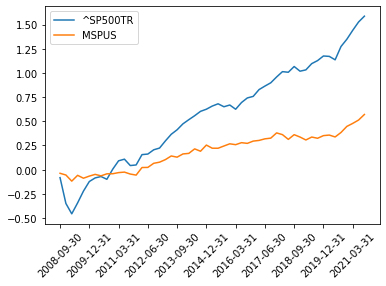

In [170]:
plt.plot(pd.concat([deltas[compare].cumsum(),deltas[target].cumsum()],axis=1),label=[compare,target])
plt.xticks(np.arange(0, len(deltas), 5),rotation = 45)
plt.legend(loc=0)
plt.show()

quarters = len(all_data.index)

target_total_return = all_data[target][-1]/all_data[target][0]
print(target,target_total_return)
compare_total_return = all_data[compare][-1]/all_data[compare][0]
print(compare,compare_total_return)

target_annualized_return = ((1 + target_total_return)**(4/quarters))-1
compare_annualized_return = ((1 + compare_total_return)**(4/quarters))-1

print(target,target_annualized_return)
print(compare,compare_annualized_return)

2007-03-31
2021-09-30
90% range and center of 3 year moving average over time span, annualized return
^SP500TR [0.04126413 0.10077235 0.11469634 0.14016705 0.15797676 0.18482247
 0.20877366]
MSPUS [-0.00365503  0.01324764  0.02279176  0.04623384  0.06384595  0.07062792
  0.08691822]


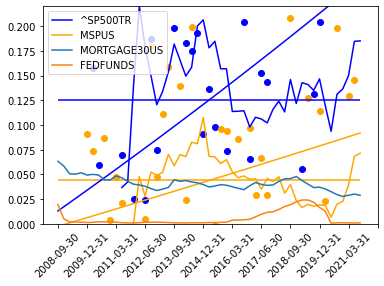

In [171]:
print(all_data.index[0])
print(all_data.index[-1])
axes = plt.axes()

print("90% range and center of 3 year moving average over time span, annualized return")

range_=[.02,.09,.25,.5,.75,.91,.98]
#[.01,.05,.10,.25,.33,.5,.66,.75,.90,.95,.99]

MA_compare = deltas[compare].rolling(window=12).mean()
MA_compare_quantiles = np.quantile([MA_compare.dropna()],range_)
print(compare,quarterly_annual_return(MA_compare_quantiles))

MA_target = deltas[target].rolling(window=12).mean()
MA_target_quantiles = np.quantile([MA_target.dropna()],range_)
print(target,quarterly_annual_return(MA_target_quantiles))

MA_M30US = all_data['MORTGAGE30US'][deltas[compare].index].rolling(window=12).mean()/100
MA_FFUNDS = all_data['FEDFUNDS'][deltas[compare].index].rolling(window=12).mean()/100

MA_M30US_quantiles = np.quantile([MA_M30US.dropna()],range_)
MA_FFUNDS_quantiles = np.quantile([MA_FFUNDS.dropna()],range_)

axes.set_ylim([0, max(pd.concat([quarterly_annual_return(MA_target.dropna()),quarterly_annual_return(MA_compare.dropna())],axis=0))])

x = range(0,len(deltas[compare]))
m, b = np.polyfit(x, deltas[compare].dropna(), 1)
plt.plot(pd.DataFrame(quarterly_annual_return(m*x + b)).set_index(deltas[compare].dropna().index),c="blue",label=compare)
plt.scatter(deltas[compare].index,quarterly_annual_return(deltas[compare]),c="blue")
plt.plot(quarterly_annual_return(MA_compare),c="blue")
plt.hlines(quarterly_annual_return(deltas[compare].mean()),xmin=deltas.index[0],xmax=deltas.index[-1],color="blue")

x = range(0,len(deltas[target]))
m, b = np.polyfit(x, deltas[target].dropna(), 1)
plt.plot(pd.DataFrame(quarterly_annual_return(m*x + b)).set_index(deltas[target].dropna().index),c="orange",label=target)
plt.scatter(deltas[target].index,quarterly_annual_return(deltas[target]),c="orange")
plt.plot(quarterly_annual_return(MA_target),c="orange")
plt.hlines(quarterly_annual_return(deltas[target].mean()),xmin=deltas.index[0],xmax=deltas.index[-1],color="orange")

plt.plot(all_data['MORTGAGE30US'][deltas[compare].index]/100,label='MORTGAGE30US')

plt.plot(all_data['FEDFUNDS'][deltas[compare].index]/100,label='FEDFUNDS')

plt.xticks(np.arange(0, len(all_data), 5),rotation = 45)
plt.legend(loc=2)
plt.show()



2011-06-30 - 2021-09-30


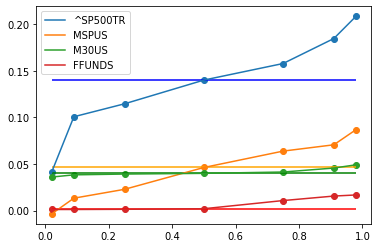

In [172]:
print(MA_compare.dropna().index[0],"-",MA_compare.dropna().index[-1])

ranged_data = pd.concat([pd.DataFrame(quarterly_annual_return(MA_compare_quantiles)),pd.DataFrame(quarterly_annual_return(MA_target_quantiles)),pd.DataFrame(MA_M30US_quantiles),pd.DataFrame(MA_FFUNDS_quantiles)],axis=1)
ranged_data.columns= [compare,target,'M30US','FFUNDS']
ranged_data.index = range_

plt.plot(ranged_data,label=ranged_data.columns)
plt.scatter(ranged_data.index,ranged_data[compare])
plt.scatter(ranged_data.index,ranged_data[target])
plt.scatter(ranged_data.index,ranged_data['M30US'])
plt.scatter(ranged_data.index,ranged_data['FFUNDS'])
plt.hlines(np.median(ranged_data[compare]),xmin=ranged_data.index[0],xmax=ranged_data.index[-1],color="blue")
plt.hlines(np.median(ranged_data[target]),xmin=ranged_data.index[0],xmax=ranged_data.index[-1],color="orange")
plt.hlines(np.median(ranged_data['M30US']),xmin=ranged_data.index[0],xmax=ranged_data.index[-1],color="green")
plt.hlines(np.median(ranged_data['FFUNDS']),xmin=ranged_data.index[0],xmax=ranged_data.index[-1],color="red")
plt.legend()
plt.show()

In [ ]:

import rpy2
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter

os.environ['R_HOME'] = 'C:/Users/User/Documents/R/R-4.1.2'
os.environ['R_LIBS'] = 'C:/Users/User/Documents/R/R-4.1.2/library'
#robjects.ro['version']

base = importr('base')
#grdevices = importr('grDevices')
grdevices = importr('graphics')
print(base._libPaths())

timetk = importr('timetk')
#importr('magrittr')
#importr('dplyr')
#importr('tidyverse')

ro.r('''
#library(dplyr)
#library(timetk)

my_mean <- function(x, na.rm=TRUE) {
  mean(x, na.rm = na.rm)
}

f <- function(y) {

#print(y)
tsfeature_tbl <- y %>%
group_by(variable) %>%
tk_tsfeatures(
  .date_var = index,
  .value    = value,
  .period   = 4,
  .features = c("frequency", "stl_features", "entropy", "acf_features", "my_mean"),
  .scale    = TRUE,
  .prefix   = "ts_"
) %>%
ungroup()
    
#library(arfima)
#varvefd = arfima(y)
#d = summary(varvefd)$coef[[1]][1]
#return(d)

print(tsfeature_tbl)

set.seed(123)

cluster_tbl <- tibble(
    cluster = tsfeature_tbl %>% 
        select(-variable) %>%
        as.matrix() %>%
        kmeans(centers = 3, nstart = 100) %>%
        pluck("cluster")
) %>%
    bind_cols(
        tsfeature_tbl
    )

print(cluster_tbl)

cluster_tbl %>%
    select(cluster, variable) %>%
    right_join(y, by = "variable") %>%
    group_by(variable) %>%
    plot_time_series(
      index, value, 
      .color_var   = cluster, 
      .facet_ncol  = 2, 
      .interactive = FALSE
    )

#return(tsfeature_tbl)
}
''')

r_f = ro.globalenv['f']

with localconverter(ro.default_converter + pandas2ri.converter):
  r_from_pd_df = ro.conversion.py2rpy(all_data.melt(ignore_index=False).reset_index())

r_from_pd_df

d=(r_f(r_from_pd_df))
print(d)


In [ ]:
def f3(Y):
    
    #Y = x
    #output_slider_variable.value
    internalFilter = filter_.copy()
    internalFilter.remove(Y)
    all_data_ = pd.concat([all_data[Y],all_data[internalFilter]], axis=1)    
    #print(all_data_.describe())
    display(all_data_.describe())
    #x_ticks = all_data_.index[np.arange(0, len(all_data.index), int(len(internalFilter)/5))]
    x_ticks  = []
    for index, element in enumerate(all_data_.index):
        if index % int(np.round(len(all_data_.index)/10)) == 0:
            x_ticks.append(element)
    plt.plot(all_data_[Y])
    plt.xticks(x_ticks, rotation = 45)
    plt.show()        
    plt.hist(all_data_[Y], bins='auto')
    plt.show()
    diff = pd.DataFrame((all_data_[Y].pct_change())).dropna()
    plt.hist(diff, bins='auto')
    plt.show()
    return(all_data_)
    
out = interactive(f3, Y=filter_)

#output_slider_variable.observe(f4, 'value')

print("choose Y")
display(out)


In [ ]:
train, test = train_test_split(out.result, test_size=tsize, shuffle=False)

d = get_deltas(train)
#differenced = pd.DataFrame(np.transpose(d.reshape(len(out.result.columns),len(out.result))))
#differenced = pd.DataFrame(np.transpose(d.reshape(len(out.result.columns),len(out.result))))


In [ ]:
cores = int(len(os.sched_getaffinity(0)))

def getDifferenced(i, data):
    #v = d[[i]]
    #gquant_gpu, weights = frac_diff(all_data.iloc[:, i], d=d[[i]], floor=5e-5)
    #print(i)
    a = np.array(data.iloc[:, i])
    
    return fdiff(a, n=d[i], axis=0)
    #gquant_gpu, weights = frac_diff(all_data.iloc[:, i]), d=v, floor=5e-5)


In [ ]:

differenced = pd.DataFrame()

for i in range(0,len(d)):
    value = pd.DataFrame(getDifferenced(i, out.result))
    #print(value)
    differenced = pd.concat([differenced,value],axis=1)
    
differenced.columns = out.result.columns
differenced.index = out.result.index    

'''

differenced_train = pd.DataFrame()

for i in range(0,len(d)):
    value = pd.DataFrame(getDifferenced(i, train))
    #print(value)
    differenced_train = pd.concat([differenced_train,value],axis=1)
    
differenced_train.columns = train.columns
differenced_train.index = train.index    

differenced_test = pd.DataFrame()
for i in range(0,len(d)):
    value = pd.DataFrame(getDifferenced(i, test))
    differenced_test = pd.concat([differenced_test,value],axis=1)

differenced_test.columns = test.columns
differenced_test.index = test.index

differenced = pd.DataFrame()
differenced = pd.concat([differenced_train,differenced_test],axis=0)
'''
differenced = pd.concat([out.result.iloc[:,0],differenced.iloc[:,1:]],axis=1)

#pool01 = concurrent.futures.ProcessPoolExecutor(cores)

#futures01 = [pool01.submit(getDifferenced, args) for args in (range(0,len(d)))]

#wait(futures01, timeout=None, return_when=ALL_COMPLETED)
#'''

'''
differenced = pd.DataFrame()
for f in range(0,len(futures01)):
    value = pd.DataFrame(futures01[f].result())
    differenced = pd.concat([differenced,value],axis=1)
    
differenced.columns = train.columns
differenced.index = train.index
'''


In [ ]:
d_ = dtale.show(out.result)
d_.open_browser()
d_._url  

In [ ]:
if False:
    for f in range(0,len(futures01)):
        #print(f)
        #print(len(futures01[f].result()))
        plt.hist(Differenced_Set.iloc[:,f], bins='auto')  # arguments are passed to np.histogram
        plt.show()
        Differenced_Set.iloc[:,1].plot()
        plt.show()
        plt.hist(all_data.iloc[:,f], bins='auto')  # arguments are passed to np.histogram
        plt.show()
        all_data.iloc[:,1].plot()
        plt.show()    



In [ ]:
c = out.result.corr()
#.abs()
s = c.unstack()
so = s.sort_values(kind="quicksort", ascending=False)

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

def critical_r(n, alpha = .05 ):
    df = n - 2
    critical_t = scipy.stats.t.isf(alpha / 2, df)
    critical_r = np.sqrt( (critical.t^2) / ( (critical.t^2) + df ) )
    return(critical_r)

def xcorr(x, y, maxlags=10):
    Nx = len(x)
    if Nx != len(y):
        raise ValueError('x and y must be equal length')

    c = np.correlate(x, y, mode=2)

    if maxlags is None:
        maxlags = Nx - 1

    if maxlags >= Nx or maxlags < 1:
        raise ValueError('maxlags must be None or strictly positive < %d' % Nx)

    c = c[Nx - 1 - maxlags:Nx + maxlags]

    return c

def getLagged_Set(set_, og):

    train, test = train_test_split(set_, test_size=tsize, shuffle=False)
    
    residuals = pd.DataFrame(np.transpose(get_residuals(train).reshape(len(train.columns),len(train))))
    #print(residuals)

    residuals.columns = train.columns
    residuals.index = train.index

    #print(len(train))
    #set_.index = all_data.index
    
    Lagged_Differenced_Set = pd.DataFrame()
    Lagged_Set = pd.DataFrame()
    lags = []
    lagcorrs = []
    ogcorrs = []

    for f in range(1,len(train.columns)):
        #print(f)
        #print(len(futures01[f].result()))

        data_1 = residuals.iloc[:,0]
        data_2 = residuals.iloc[:,f]

        ogc = np.array(pd.concat([data_1 - np.mean(data_1),data_2 - np.mean(data_2)],axis=1).corr())[1,0]    
        ogcorrs.append(ogc)

        #corr = xcorr(data_1 - np.mean(data_1), data_2 - np.mean(data_2),maxlags=5)

        set1 = data_1 - np.mean(data_1)
        set2 = data_2 - np.mean(data_2)

        corrs_ = []
        for i in range(0,maxl):
            c = np.array((pd.concat([set1,set2.shift(i)],axis=1).dropna()).corr())[0,1]
            corrs_.append(c)

        #corr = np.correlate(data_1 - np.mean(data_1), data_2 - np.mean(data_2),mode='full')
        #plt.plot(corr)
        #plt.show()

        #lag = corr.argmax() - (len(data_1) - 1)
        lag = abs(pd.Series(corrs_)).idxmax()

        #print(corr)
        lagc = np.array(pd.concat([data_1 - np.mean(data_1),(data_2 - np.mean(data_2)).shift(lag)],axis=1).corr())[1,0]

        #print(lag)

        #print(ogc)
        #print(lagc)

        #print(lag)
        #plt.plot(data_1, 'r*')
        #plt.plot(data_2, 'b*')

        lag_merged = pd.concat([data_1 - np.mean(data_1),(data_2 - np.mean(data_2)).shift(lag)],axis=1)

        #x_ticks = all_data.index[np.arange(0, len(all_data.index), 5)]
        #plt.xticks(x_ticks, rotation = 45)    
        #plt.show()

        #plt.scatter(data_2.shift(lag),data_1)
        #plt.show()

        #plot_acf(data_2.shift(lag))
        #plt.show()

        #plot_pacf(data_2.shift(lag))
        #plt.show()

        #y = data_1
        #X = data_2
        #reg = LinearRegression().fit(X, y)

        #print(reg.score(X, y),reg.coef_,reg.intercept_)

        #model = sm.OLS(y,X)
        #results = model.fit()
        #print(results.summary())

        #Lagged_Differenced_Set = pd.concat([Lagged_Differenced_Set,data_2.shift(lag)],axis=1)
        #TrainO_Lagged_Set = pd.concat([TrainO_Lagged_Set,all_data.iloc[:,f].shift(lag)],axis=1)
        #if lag>0:
            #lag = 0

        Lagged_Set = pd.concat([Lagged_Set,og.iloc[:,f].shift(lag)],axis=1)

        lagcorrs.append(lagc)

        lags.append(lag)

    Lagged_Set.index = set_.index
    #stats = pd.concat([pd.DataFrame(set_.columns[1:]),pd.DataFrame(lags),pd.DataFrame(lagcorrs),pd.DataFrame(ogcorrs)],axis=1)
    stats = pd.concat([pd.DataFrame(set_.columns[1:]),pd.DataFrame(lags),pd.DataFrame(ogcorrs)],axis=1)
    
    #print(Lagged_Set)
    #return stats, pd.concat([data_1,Lagged_Set],axis=1),  pd.concat([data_1,Lagged_Differenced_Set],axis=1)
    return stats, pd.concat([set_.iloc[:,0],Lagged_Set],axis=1)


In [ ]:
Lagged_Set = pd.DataFrame()
Lagged_Differenced_Set = pd.DataFrame()

#'''
#Lagged_Differenced_Set_offset = pd.concat([out.result.iloc[:,0].pct_change().shift(-1),out.result.iloc[:,1:].pct_change()],axis=1)
differenced_set = out.result.pct_change()
differenced_set = differenced_set.replace([np.inf, -np.inf, np.NaN], 0)

ls_stats, Lagged_Differenced_Set= getLagged_Set(differenced_set, out.result)
lso_stats, Lagged_Differenced_Set_offset= getLagged_Set(pd.concat([differenced_set.iloc[:,0].shift(-1),differenced_set.iloc[:,1:]],axis=1), out.result)
#add in last period of y
Lagged_Differenced_Set_offset = pd.concat([Lagged_Differenced_Set_offset.iloc[:,0],differenced_set.iloc[:,0],Lagged_Differenced_Set_offset.iloc[:,1:]],axis=1)
#Lagged_Set_offset.index = out.result.index
Lagged_Differenced_Set.dropna(inplace= True)
#Lagged_Set_offset.columns = out.result.columns

Lagged_Differenced_Set_offset.dropna(inplace= True)

#Lagged_Differenced_Set.dropna(inplace= True)


In [ ]:
'''
temp = pd.DataFrame()
temp = pd.concat([out.result.iloc[:,0].pct_change().shift(-1),Lagged_Set_offset.iloc[:,1:].pct_change()],axis=1).copy()
Lagged_Differenced_Set_offset = pd.DataFrame()
Lagged_Differenced_Set_offset = temp.copy()
Lagged_Differenced_Set_offset.dropna(inplace= True)
Lagged_Differenced_Set_offset
Lagged_Differenced_Set_offset = Lagged_Differenced_Set_offset.replace([np.inf, -np.inf, np.NaN], 0)
#Lagged_Differenced_Set_offset.fillna(0)
#preprocessing.StandardScaler().fit(Lagged_Differenced_Set_offset)
'''
np.sum(Lagged_Differenced_Set_offset.isin([np.inf, -np.inf, np.NaN])).sort_values(kind="quicksort", ascending=True)

In [ ]:
print(ls_stats)
print(lso_stats)

In [ ]:
#skip correlation
#Lagged_Differenced_Set_offset = pd.concat([our.result.iloc[:,0].pct_change().shift(-1),differenced_set.iloc[:,0],Lagged_Differenced_Set_offset.iloc[:,1:]],axis=1)
#Lagged_Set_offset.index = out.result.index
#Lagged_Differenced_Set.dropna(inplace= True)

set_ = Lagged_Differenced_Set
set_ = pd.concat([differenced_set.iloc[:,0].shift(-1),differenced_set.iloc[:,0],differenced_set.iloc[:,1:]],axis=1)
set_.dropna(inplace=True)
set_ = set_.tail(-1)
transformed, lambdas = transform_boxcox(set_.dropna())

#revert_yeo(Lagged_Differenced_Set_offset, transformed, lambdas)

In [ ]:
cbd = True
ic = True

# evaluate an elastic net model on the dataset
#tsize = .20
#train, test = train_test_split(Lagged_Differenced_Set_offset.iloc[:,0:], test_size=tsize, shuffle=False)
train, test = train_test_split(transformed.iloc[:,0:], test_size=tsize, shuffle=False)

interaction = PolynomialFeatures(degree=2, include_bias=False, interaction_only=ic)

#train_t, lambdas_t = transform_boxcox(train)

#disabled boxcox
if cbd:
    train_t = train

scaler = preprocessing.StandardScaler().fit(train_t)

#
train_s = pd.DataFrame(scaler.transform(train_t))
train_s.columns = train.columns
train_s.index = train.index  

train_t = train_s

#test_t = transform_boxcox_l(test, lambdas_t)

#disabled boxcox
if cbd:
    test_t = test

test_s = pd.DataFrame(scaler.transform(test_t))
test_s.columns = test.columns
test_s.index = test.index

test_t = test_s

y_train = pd.DataFrame(train_t.iloc[:,0])

#exclude y

X_inter_train = pd.DataFrame(interaction.fit_transform(train_t.iloc[:,1:]), columns=interaction.get_feature_names(input_features=pd.DataFrame(train_t.iloc[:,1:]).columns))

    #apply ZCA each time a set of factors are removed (i.e. iteratively)
 #trf = zca.ZCA().fit(X_inter_train)
  #trf = zca.ZCA().fit(X_train)

 #X_train = pd.DataFrame(trf.transform(X_inter_train))
  #X_train = pd.DataFrame(trf.transform(X_train))
 #X_train.columns=X_inter_train.columns
  #X_train.columns=X_train.columns
  #X_train.index = train.index

#X_inter_alt = X_train.iloc[:, np.array(range(0,len(all_data.iloc[:,2:].columns)))]
#print(X_inter_alt.head(3))

y_test = pd.DataFrame(test_t.iloc[:,0])

X_inter_test = pd.DataFrame(interaction.fit_transform(test_t.iloc[:,1:]), columns=interaction.get_feature_names(input_features=pd.DataFrame(test_t.iloc[:,1:]).columns))

 #X_test = pd.DataFrame(trf.transform(X_inter_test))
  #X_test = pd.DataFrame(trf.transform(X_test))

 #X_test.columns=X_inter_test.columns
  #X_test.columns=X_test.columns
  #X_test.index = test.index

#X_inter_t_alt = X_test.iloc[:, np.array(range(0,len(all_data.iloc[:,2:].columns)))]
#X_inter_t_alt.head()


In [ ]:
# define model evaluation method
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from scipy.stats import randint

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define model
ratios = arange(0, 1, 0.01)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]

 #model = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=4, verbose=0, precompute='auto')

model = ElasticNet()
grid = dict()
# fit model

grid['alpha'] = alphas
grid['l1_ratio'] = ratios

#search = HalvingRandomSearchCV(model, grid,resource='n_samples',max_resources=10,random_state=0)

search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

 #results = search.fit(X_inter_train, y_train)
#results = search.fit(X_train, y_train)

results = search.fit(X_inter_train, y_train)

 #model.fit(X_inter_train, y_train)
# summarize chosen configuration

print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

print(results.best_estimator_)
best_model = ElasticNet(alpha=results.best_estimator_.alpha, l1_ratio = results.best_estimator_.l1_ratio)

#pd.concat([all_data[Y],all_data_int],axis=1)



In [ ]:
best_model.fit(X_inter_train,train_t.iloc[:,0])

trainScore = best_model.score(X_inter_train, y_train, sample_weight=None)
testScore = best_model.score(X_inter_test, y_test, sample_weight=None)
print(trainScore)
print(testScore)


In [ ]:
#classification transforms
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
interaction = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
from sklearn.model_selection import StratifiedShuffleSplit
import random
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SVMSMOTE 
from scipy import stats


#set_ = Lagged_Differenced_Set_offset.copy()
#set_ = transformed.copy()
#DF_list = list()

sets = list()
sets.append(transformed.copy())
#sets.append(Lagged_Differenced_Set_offset.copy())
sets.append(set_.copy())

def return_sets(sets):    
    
    sets_outer = list()
    
    for i in sets:
        
        sets_multiple = list()
        
        set_ = pd.DataFrame()
        set_ = i

        X, y = set_.iloc[:,1:],  set_.iloc[:,0]
        
        print(mean(y))

        y = pd.DataFrame(np.where(y > mean(y), 1, 0))
        y.index = set_.index

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=tsize, shuffle=False)

        a = set_.iloc[:,0].loc[X_train.index]
        b = set_.iloc[:,0].loc[X_test.index]
        plt.hist(a)
        plt.show()
        plt.hist(b)
        plt.show()
        print(stats.ttest_ind(a,b, equal_var = False))

        one = y_train[y_train==0].dropna().sample(int(len(X_train)*2), replace=True, random_state=1)
        two = y_train[y_train==1].dropna().sample(int(len(X_train)*2), replace=True, random_state=1)

        train_index = np.append(one.index,two.index)

        #destroyed my data
        #smote = SVMSMOTE(random_state=42)
            #smote = SMOTE()
        #Xsm_train, ysm_train = smote.fit_sample(np.array(X_train),np.array(y_train))

        Xsm_train = X_train.copy()
        ysm_train = y_train.copy()
        
        #use with optimal lags
        #y_test = y_test.loc[y_test.index>y_test.index[maxl]]
        #X_test = X_test.loc[X_test.index>X_test.index[maxl]]

        scaler = preprocessing.StandardScaler().fit(Xsm_train)

        X_train_transformed = pd.DataFrame(scaler.transform(Xsm_train))
        X_train_transformed.columns = X_train.columns

        X_inter_train = X_train_transformed.copy()

        #X_inter_train = pd.DataFrame(interaction.fit_transform(X_train_transformed), columns=interaction.get_feature_names(input_features=pd.DataFrame(X_train_transformed).columns))

        trf = zca.ZCA().fit(X_inter_train)

        #X_inter_train = pd.DataFrame(trf.transform(X_inter_train))
        X_inter_train.columns=pd.DataFrame(X_inter_train).columns
        #X_inter_train.index = X_train.loc[train_index].index

        X_test_transformed = pd.DataFrame(scaler.transform(X_test))
        X_test_transformed.columns = X_test.columns
        X_test_transformed.index = X_test.index

        X_inter_test = X_test_transformed

        #X_inter_test = pd.DataFrame(interaction.fit_transform(X_test_transformed), columns=interaction.get_feature_names(input_features=pd.DataFrame(X_test_transformed).columns))

        #X_inter_test = pd.DataFrame(trf.transform(X_inter_test))

        sets_multiple.append(X_inter_train)
        sets_multiple.append(y_train)
        sets_multiple.append(X_inter_test)
        sets_multiple.append(y_test)        
    
        sets_outer.append(sets_multiple)
        
    return(sets_outer)

values = return_sets(sets)


In [ ]:
#SVM

#works best
#class balanced, no zca
from sklearn import svm

for i in range(0,len(sets)):
    
    X_train = values[i][0]
    y_train = values[i][1]
    X_test = values[i][2]
    y_test = values[i][3]

    clf = svm.SVC(kernel='rbf', C=1, random_state=42)

    scores = cross_val_score(clf, X_train, y_train, cv=10)

    print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

    clf = svm.SVC(C=1).fit(X_train, y_train)

    train_predict = clf.predict(X_train)
    predicteds = clf.predict(X_test)
    #predicted.index = y_test.index

    print(clf.score(X_train, y_train))
    print(clf.score(X_test, y_test))

    #clf.predict(X_test)
    #print(predicteds)
    print(metrics.classification_report(y_train,train_predict))
    print(metrics.classification_report(y_test,predicteds))
    print(metrics.confusion_matrix(y_train,train_predict))
    print(metrics.confusion_matrix(y_test,predicteds))

    predictions_s = arima_adjust(y_train, y_test, train_predict, predicteds)



In [ ]:
'''
from sklearn.pipeline import Pipeline
pipe = Pipeline([('scaler', StandardScaler()),('svc', svm.SVC(kernel='sigmoid', C=1, random_state=42))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)
'''
#search = cross_val_score(pipe, X_inter_train, y_train.loc[train_index], cv=10)
#GridSearchCV(pipe, param_grid, n_jobs=-1)
#search.fit(X_digits, y_digits)
#print("Best parameter (CV score=%0.3f):" % search.best_score_)
#print(search.best_params_)

In [ ]:
#Logistic1
from sklearn.linear_model import LogisticRegression
for i in range(0,len(sets)):
    
    X_train = values[i][0]
    y_train = values[i][1]
    X_test = values[i][2]
    y_test = values[i][3]

    modell = LogisticRegression()
    modell.fit(X_train, y_train)
    print(modell)

    #expected = y_test
    train_predict = modell.predict(X_train)
    predictedl = modell.predict(X_test)

    print(modell.score(X_train, y_train))
    print(modell.score(X_test, y_test))

    #clf.predict(X_test)
    #print(predicteds)
    print(metrics.classification_report(y_train,train_predict))
    print(metrics.classification_report(y_test,predictedl))
    print(metrics.confusion_matrix(y_train,train_predict))
    print(metrics.confusion_matrix(y_test,predictedl))
    
    predictions_l = arima_adjust(y_train, y_test, train_predict, predictedl)


In [ ]:
#Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

for i in range(0,len(sets)):
    
    X_train = values[i][0]
    y_train = values[i][1]
    X_test = values[i][2]
    y_test = values[i][3]

    modeln = GaussianNB()
    modeln.fit(X_train, y_train)
    print(modeln)

    #expected = y_test
    train_predict = modeln.predict(X_train)
    predictedn = modeln.predict(X_test)

    print(modeln.score(X_train, y_train))
    print(modeln.score(X_test, y_test))

    #clf.predict(X_test)
    #print(predicteds)
    print(metrics.classification_report(y_train,train_predict))
    print(metrics.classification_report(y_test,predictedn))
    print(metrics.confusion_matrix(y_train,train_predict))
    print(metrics.confusion_matrix(y_test,predictedn))
    
    predictions_n = arima_adjust(y_train, y_test, train_predict, predictedn)


In [ ]:
#DecisionTreeClassifier
#works best with transformed
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

for i in reversed(range(0,len(sets))):
    
    X_train = values[i][0]
    y_train = values[i][1]
    X_test = values[i][2]
    y_test = values[i][3]

    modeld = DecisionTreeClassifier()
    modeld.fit(X_train, y_train)
    print(modeld)

    #expected = y_test
    train_predict = modeld.predict(X_train)
    predictedd = modeld.predict(X_test)

    print(modeld.score(X_train, y_train))
    print(modeld.score(X_test, y_test))

    #clf.predict(X_test)
    #print(predicteds)
    print(metrics.classification_report(y_train,train_predict))
    print(metrics.classification_report(y_test,predictedd))
    print(metrics.confusion_matrix(y_train,train_predict))
    print(metrics.confusion_matrix(y_test,predictedd))
        
    predictions_d = arima_adjust(y_train, y_test, train_predict, predictedd)


In [ ]:
#knn
#works best with transformed

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV#create new a knn model

for i in range(0,len(sets)):
    
    X_train = values[i][0]
    y_train = values[i][1]
    X_test = values[i][2]
    y_test = values[i][3]
    
    knn2 = KNeighborsClassifier(metric='euclidean',weights='distance')#create a dictionary of all values we want to test for n_neighbors
    param_grid = {'n_neighbors': np.arange(1, 25)}#use gridsearch to test all values for n_neighbors
    knn_gscv = GridSearchCV(knn2, param_grid, cv=5)#fit model to data
    knn_gscv.fit(X_train, y_train)
    #check top performing n_neighbors value
    print(knn_gscv.best_params_)
    #check mean score for the top performing value of n_neighbors
    print(knn_gscv.best_score_)

    modelk = KNeighborsClassifier(n_neighbors = knn_gscv.best_params_['n_neighbors'],metric='euclidean',weights='distance')
    modelk.fit(X_train,y_train)
    train_predict = modelk.predict(X_train)
    predictedk = modelk.predict(X_test)
    #modelk.score(X_test, y_test)

    print(modelk.score(X_train, y_train))
    print(modelk.score(X_test, y_test))

    #clf.predict(X_test)
    #print(predicteds)
    print(metrics.classification_report(y_train,train_predict))
    print(metrics.classification_report(y_test,predictedk))
    print(metrics.confusion_matrix(y_train,train_predict))
    print(metrics.confusion_matrix(y_test,predictedk))
    
    predictions_k = arima_adjust(y_train, y_test, train_predict, predictedk)


In [ ]:
'''
#Elastic logistic
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
# define model
ratios = arange(0, 1, 0.01)
alphas = (10 ** np.linspace(-1, 1, 10))/10
alphas = np.append(alphas,[10.0, 100.0])

model = SGDClassifier(loss="log", penalty="elasticnet")
grid = dict()
# fit model

grid['alpha'] = alphas
grid['l1_ratio'] = ratios

search_l = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

results_l = search_l.fit(X_inter_train, ysm_train)

 #model.fit(X_inter_train, y_train)
# summarize chosen configuration

print('MAE: %.3f' % results_l.best_score_)
print('Config: %s' % results_l.best_params_)

from sklearn.calibration import CalibratedClassifierCV
print(results_l.best_estimator_)
best_model_l = SGDClassifier(alpha=results_l.best_estimator_.alpha, l1_ratio = results_l.best_estimator_.l1_ratio)

#calibrator = CalibratedClassifierCV(best_model_l, cv='prefit')
#model=calibrator.fit(X_inter_train, y_train)

best_model_l.fit(X_inter_train,ysm_train)

#sgd = SGDClassifier()

#sgd.partial_fit(X_inter_train,y_train, classes=[0,1])

print(pd.DataFrame(np.transpose(best_model_l.coef_)).set_index(X_inter_train.columns))

trainScore_l = best_model_l.score(X_inter_train, ysm_train, sample_weight=None)
testScore_l = best_model_l.score(X_inter_test, y_test, sample_weight=None)
print(trainScore_l)
print(testScore_l)

#print(help(KNeighborsClassifier))
predictedl = best_model_l.predict(X_inter_test)

'''

In [ ]:
mean(y_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

#predictedf = pd.concat([pd.DataFrame(predicteds),pd.DataFrame(predictedk),pd.DataFrame(predictedl)],axis=1)
predictedf = pd.concat([pd.DataFrame(predictions_s),pd.DataFrame(predictions_k),pd.DataFrame(predictions_d),pd.DataFrame(predictions_l),pd.DataFrame(predictions_n)],axis=1)
predictedf.columns = ["s","k","d","l","n"]
predictedf.index = y_test.index
print(predictedf)
print(confusion_matrix(y_test, predictedf.mode(axis=1).iloc[:,0]))
#print(confusion_matrix(y_test, predictedf.median(axis=1)))
print(classification_report(y_test, predictedf.mode(axis=1).iloc[:,0]))
#print(classification_report(y_test, predictedf.median(axis=1)))

print(mean(y_test))

In [ ]:
# multivariate output multi-step 1d cnn example
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dense, SimpleRNN, GRU, LSTM
from keras.optimizers import SGD
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

#Lagged_Differenced_Set = (all_data - all_data.shift(-1)).dropna()
choice = pd.concat([out.result.iloc[:,0],differenced_set],axis=1)

train, test = train_test_split(choice, test_size=tsize, shuffle=False)

transformed_train, lambdas_ = transform_boxcox(train)
transformed_test = transform_boxcox_l(test, lambdas_)
scaler = preprocessing.StandardScaler().fit(transformed_train)
train_s = pd.DataFrame(scaler.transform(transformed_train))
test_s = pd.DataFrame(scaler.transform(transformed_test))

#scaler = preprocessing.StandardScaler().fit(train)
#train_s = pd.DataFrame(scaler.transform(train))
#test_s = pd.DataFrame(scaler.transform(test))

combined = pd.concat([train_s,test_s],axis=0)
combined.index = choice.index
combined.columns = choice.columns

set_ = combined

def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out, xcolumns, ycolumns):
    
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, xcolumns], sequences[end_ix:out_end_ix, ycolumns]
        X.append(seq_x)
        y.append(seq_y)
    
    return array(X), array(y)

#n_steps_in = int(np.floor(len(train)*.8))
print(len(set_))
n_steps_in = int(np.round(len(set_)/2))
print(len(set_) - n_steps_in)
print(n_steps_in)
#n_steps_out = int(len(train)-n_steps_in)
n_steps_out = 1
print(n_steps_out)

#ycolumns = range(0,len(transformed.columns))
ycolumns = range(0,len(set_.columns[0:1].values))
xcolumns = range(1,len(set_.columns[1:]))

#trainInner, valid = train_test_split(trainOuter, test_size=0.15, shuffle=False)
#trainInner_whitened = pd.DataFrame(trf.transform(trainInner.iloc[:,1:])).set_index(trainInner.index)
#valid_whitened = pd.DataFrame(trf.transform(valid.iloc[:,1:])).set_index(valid.index)
#test_whitened = pd.DataFrame(trf.transform(test.iloc[:,1:])).set_index(test.index)

#trainOuter_whitened=pd.DataFrame(trf.transform(trainOuter.iloc[:,1:])).set_index(trainOuter.index)

X, y = split_sequences(np.array(set_), n_steps_in, n_steps_out, xcolumns, ycolumns)

#for i in range(len(X)):
#    print(X[i], y[i])
    
#flatten output

if len(ycolumns) > 0:
    n_output = y.shape[1] * y.shape[2]
    y = y.reshape((y.shape[0], n_output))

n_features = X.shape[2]

# define model
modelCNN = keras.models.Sequential([
    keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)),
    keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)),
    keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)),
    keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)),
    keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)),
    keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)),
    keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)),
    keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(n_output)
])

# fit model
#model.fit(X, y, epochs=7000, verbose=0)

epochs_ = 2000
batch_size_ = 25

#np.random.seed(42)
#tf.random.set_seed(42)


#model.compile(optimizer='adam', loss='mse')
modelCNN.compile(loss="MAPE", optimizer="rmsprop",metrics=['MAPE'])

#model6.compile(loss="MAPE", optimizer="rmsprop",metrics=['MAPE'])

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=tsize,
                                                    shuffle = False)
                                                    #random_state=42)
#scaler = preprocessing.StandardScaler().fit(X_train)

#X_train_transformed = pd.DataFrame(scaler.transform(X_train))
#X_train_transformed.columns = X_train.columns

#X_test_transformed = pd.DataFrame(scaler.transform(X_test))
#X_test_transformed.columns = X_test.columns
#X_test_transformed.index = X_test.index

    #new_series = pd.DataFrame(ts_train_scaled).append(pd.DataFrame(ts_valid_scaled)).append(pd.DataFrame(ts_test_scaled))

    #series_reshaped = np.array([new_series[i:i + (n_steps+n_ahead)].copy() for i in range(len(data) - (n_steps+n_ahead))])  
    
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,
                                                    test_size=tsize,
                                                    shuffle = False)
                                                    #random_state=42)    

#model6.compile(loss="MAPE", optimizer="rmsprop",metrics=['MAPE'])
historyCNN = modelCNN.fit(X_train, y_train, epochs=epochs_,batch_size=batch_size_,validation_data=(X_valid, y_valid), verbose=0)
#history6 = model6.fit(X_train, y_train, epochs=epochs_,batch_size=batch_size_,validation_data=(X_valid, y_valid), verbose=0)
#history = model.fit(X_train, y_train, epochs=epochs_,batch_size=batch_size_,verbose=0)


In [ ]:
#need to apply to test
#revert_boxcox(pd.DataFrame(transformed_.iloc[:,0]),pd.DataFrame(lambdas[0]))
#Lagged_Differenced_Set

In [ ]:
import matplotlib as mpl
plot_learning_curves(historyCNN.history["loss"], historyCNN.history["val_loss"])
plt.show()
#plot_learning_curves(history6.history["loss"], history.history["val_loss"])
#plt.show()

In [ ]:
type(revert_transformed_predicted)

In [ ]:
import matplotlib.pyplot as plt
#multi
yhat = modelCNN.predict(X_test, verbose=0)

predicted = []
original = []
if len(ycolumns) > 1:
    results = yhat.reshape(len(y_test), int(yhat.shape[1]/X_test.shape[2]), len(choice.columns))
    for i in range(0,len(results)):
        predicted.append(pd.DataFrame(results[i])[0][0])
        original.append(pd.DataFrame(y_test[i])[0][0])
        #print(pd.DataFrame(results[i])[0][0])
        #print(pd.DataFrame(y_test[i])[0][0])
else:
    results = yhat
    for i in range(0,len(results)):
        predicted.append(results[i])
        original.append(y_test[i])
        #print(pd.DataFrame(results[i]))
        #print(pd.DataFrame(y_test[i]))
        
#revert_transformed_predicted = inverse_yeo((scaler.mean_[0]+scaler.scale_[0]*pd.DataFrame(predicted)).values,(scaler.mean_[0]+scaler.scale_[0]*pd.DataFrame(predicted)).values,lambdas_.values[0])
#revert_transformed_original = inverse_yeo((scaler.mean_[0]+scaler.scale_[0]*pd.DataFrame(original)).values,(scaler.mean_[0]+scaler.scale_[0]*pd.DataFrame(original)).values,lambdas_.values[0])
revert_transformed_predicted = (scaler.mean_[0]+scaler.scale_[0]*pd.DataFrame(predicted))
revert_transformed_original = (scaler.mean_[0]+scaler.scale_[0]*pd.DataFrame(original))

plt.scatter(revert_transformed_predicted,revert_transformed_original)
temp = pd.concat([revert_transformed_predicted,revert_transformed_original],axis=1)
temp.columns = ["predicted", "original"]
display(temp)

In [ ]:
coef = pd.DataFrame(best_model.coef_).set_index(X_inter_train.columns)

a_coef = abs(coef)
a_coef.sort_values(by=[0],ascending=False,inplace=True)
chosen_few = a_coef[a_coef>0].dropna().index.values

scaler_ = preprocessing.StandardScaler().fit(transformed)

#
train_ = pd.DataFrame(scaler_.transform(transformed))
train_.columns = transformed.columns
train_.index = transformed.index  

X_inter_train_ = pd.DataFrame(interaction.fit_transform(train_.iloc[:,1:]), columns=interaction.get_feature_names(input_features=pd.DataFrame(train_.iloc[:,1:]).columns))

max_pvalue = 1
New_Names = X_inter_train.columns
X_b = X_inter_train_[chosen_few]
while (max_pvalue > .05):
        
    trf = zca.ZCA().fit(X_b)
        
    X_b_z = pd.DataFrame(trf.transform(X_b))
    X_b_z.columns=pd.DataFrame(X_b).columns
    X_b_z.index = train_.index

    model_ = sm.OLS(train_.iloc[:,0],sm.tools.tools.add_constant(X_b_z, prepend=True, has_constant='skip'))        
    #model_ = sm.OLS(pd.DataFrame(pd.concat([train_.iloc[:,0],X_b_z],axis=1),sm.tools.tools.add_constant(X_b_z, prepend=True, has_constant='skip'))        
    results_ = model_.fit()

    set_ = X_b.columns.tolist()
    
    max_pvalue = max(results_.pvalues[1:])
    if (max_pvalue > .05):
        print(max_pvalue)
        max_pname = (results_.pvalues[1:]).idxmax(axis=1)
        set_.remove(max_pname)
        New_Names = set_
    
        X_b = X_inter_train_[New_Names]
        X_b.index = X_inter_train_.index

#from statsmodels.formula.api import ols
#lm = ols(pd.DataFrame(train_.iloc[:,0]) ~ sm.tools.tools.add_constant(X_b_z, prepend=True, has_constant='skip')).fit()
#table = sm.stats.anova_lm(model_, type=3)
#print(table)
print(results_.summary())

In [ ]:
def findNaNCols(df_):
    for col in df_:        
        num_NaNs = df_[col].isnull().sum()
        if num_NaNs > 0:
            print(f"Column: {col}")
            print(f"Number of NaNs: {num_NaNs}")

findNaNCols(X_b_z)

In [ ]:

linear_plot = Plot.LinearRegressionResidualPlot(X_b_z, pd.DataFrame(train_.iloc[:,0]))
lm = linear_plot.fit()
summary, diag_res = linear_plot.diagnostic_plots(lm)
print("Summary of Regression\n:{}".format(summary))
print("Diagnostic Tests of Regression\n:{}".format(diag_res))

plt.show()

%matplotlib inline

#sns.pairplot(pd.concat([pd.DataFrame(train[Y]),X_b_z],axis=1), hue=Y, height=2);

pd.concat([pd.DataFrame(train[Y]),X_b_z],axis=1).hist()

plt.show()

model_s = sklearn.linear_model.LinearRegression()
model_s.fit(X_b_z, pd.DataFrame(train_[Y]))

shap.initjs()
e = shap.explainers.Linear(model_s, X_b_z)

shap_values = e.shap_values(X_b_z)
shap.summary_plot(shap_values, X_b_z)
shap.plots.heatmap(e(X_b_z))

In [ ]:
from scipy.stats import f

from statsmodels.graphics.gofplots import ProbPlot
residuals_normalized = lm.get_influence().resid_studentized_internal
cooks = lm.get_influence().cooks_distance[0]
cooks = np.round(f.pdf(cooks,len(lm.tvalues)+1, len(lm.fittedvalues)-len(lm.tvalues)-1),2)

res_std = lm.get_influence().resid_std

leverage = lm.get_influence().hat_matrix_diag

plt.hist(pd.DataFrame(leverage))
plt.show()

plt.hist(pd.DataFrame(cooks))
plt.show()

plt.hist(pd.DataFrame(residuals_normalized))
plt.show()


testNormal(residuals_normalized)

w = res_std
x = cooks
y = leverage
z = residuals_normalized

fitted_y = lm.fittedvalues

labels_ = fitted_y.index

outlier_check = pd.concat([pd.DataFrame(x),pd.DataFrame(y),pd.DataFrame(z),pd.DataFrame(w)],axis=1).set_index(labels_)

outlier_check.columns =  ['cooks', 'leverage', 'tsres', 'sres']

qq = ProbPlot(residuals_normalized)

c_thresh = .1
l_thresh = (2*(len(lm.tvalues)-1)/len(lm.fittedvalues))
s_thresh = max(qq.theoretical_quantiles)

print("Outlier threshold's")
print("Cooks distance: > .1+")
print("Leverage: > " + str(l_thresh) + " to " + str(3 * (len(lm.tvalues)-1)/len(fitted_y)))
print("Studentized residuals: > " + str(s_thresh))
print()

flag = []

for i in range(0,len(outlier_check)):
    if( (outlier_check.iloc[i][0] >= c_thresh) or (outlier_check.iloc[i][1] >= l_thresh) or (abs(outlier_check.iloc[i][2]) >= s_thresh) ):
        print(outlier_check.iloc[i])
        print()
        flag.append(True)
    else:
        flag.append(False)

outlier_check = pd.concat([outlier_check,pd.DataFrame(flag).set_index(labels_)],axis=1)

outlier_check.columns =  ['cooks', 'leverage', 'tsres', 'sres', 'flagged']

print(np.flip(np.argsort(cooks), 0))
#print(outlier_check)

search = outlier_check[outlier_check['flagged']==1].index.to_list()

rows = []

for i in search:
    v = outlier_check.index.to_list().index(i)
    rows.append(v)

print(rows)

In [ ]:
def custom_style(row):

    color = 'white'
    if bool(row.flagged) == True:
        color = 'orange'

    return ['background-color: %s' % color]*len(row.values)

all_data[set(all_data.columns) & set(New_Names)]

outlier_check.style.apply(custom_style, axis=1).apply(custom_style, axis=1).background_gradient(cmap ='viridis')


In [ ]:
df1 = y_train.columns.to_list()
df2 = list(set(set(all_data.columns) & set(New_Names)))

flattened = [] 
for sublist in df1,df2: 
    for val in sublist: 
        flattened.append(val) 

all_data.iloc[rows][flattened].style.background_gradient(cmap ='viridis')